# 大数据分析
## 第二次作业

__首先导入必要的库__

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from scipy import sparse 
from scipy.stats import norm
from numpy import *
import warnings
warnings.filterwarnings("ignore")

# 一、数据预处理
__数据直接通过pandas直接读入__    
__为了方便将数据做成矩阵，这里对用户ID做了一个映射，UID -> {0 - 9999}。同样，对电影的ID也做了映射 MID -> {0 - 9999}__    
__另外为了避免每次启动程序执行该过程，所及将映射完成之后的数据保存本地文件，下次可以直接读入__

In [2]:
#是否读取原始数据
F_netflix_test = 'netflix_test.csv'
F_netflix_train = 'netflix_train.csv'
F_users = 'users.csv'
F_movie_titles = 'movie_titles.csv'
F_users_T = 'users_T.csv'
if os.path.exists(F_netflix_test)==False \
    or os.path.exists(F_netflix_train)==False \
    or os.path.exists(F_users)==False \
    or os.path.exists(F_movie_titles)==False \
    or os.path.exists(F_users_T)==False:
    print '从原始数据读取并处理。'
    #数据读入
    df_file_test = pd.read_csv('netflix_test.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_train = pd.read_csv('netflix_train.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_users = pd.read_csv('users.txt' , sep=' ' , header = None , names = ['UID'])
    #用户INDEX与之用户ID的对应表，和df_file_users构成逆表关系，互查
    df_file_users_T = df_file_users[:]
    df_file_users_T = df_file_users_T.reset_index()
    df_file_users_T = df_file_users_T.set_index('UID')
    df_file_users_T.rename(columns = {'index':'UIDX'},inplace=True)
    #训练测试数据添加UIDX列保证UIDX取值范围控制再在0~9999之间
    df_file_train_UIDX = df_file_train['UID']
    df_file_test_UIDX = df_file_test['UID']
    for index in df_file_users_T.index.values:
        df_file_train_UIDX = df_file_train_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
        df_file_test_UIDX = df_file_test_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
    df_file_train['UIDX'] = df_file_train_UIDX
    df_file_test['UIDX'] = df_file_test_UIDX
    #训练测试数据添加MIDX列保证MIDX取值范围控制再在0~9999之间
    df_file_train['MIDX'] = df_file_train['MID'] - 1
    df_file_test['MIDX'] = df_file_test['MID'] - 1
    #保存
    df_file_test.to_csv(F_netflix_test)
    df_file_train.to_csv(F_netflix_train)
    df_file_users.to_csv(F_users)
    df_file_titles.to_csv(F_movie_titles)
    df_file_users_T.to_csv(F_users_T)
else:
    print '直接读取已有数据。'
    df_file_test = pd.read_csv(F_netflix_test)
    df_file_train = pd.read_csv(F_netflix_train)
    df_file_users = pd.read_csv(F_users)
    df_file_titles = pd.read_csv(F_movie_titles)
    df_file_users_T = pd.read_csv(F_users_T)
print '数据读入完成！'

直接读取已有数据。
数据读入完成！


__完成数据读入后，将数据看作悉数矩阵数据装入（sparse.coo_matrix），然后直接张成一张完整的10000 * 10000的矩阵__    
__训练数据与测试结果数据相同处理方式，这一步得到矩阵X_train和X_test__

In [3]:
#创建训练和测试矩阵
row = df_file_train['UIDX'].values
col = df_file_train['MIDX'].values
data= df_file_train['score'].values
X_train = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_train = mat(X_train)
row = df_file_test['UIDX'].values
col = df_file_test['MIDX'].values
data= df_file_test['score'].values
X_test = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_test = mat(X_test)

__接下来生成训练矩阵和测试矩阵的标记矩阵__     
__另外本题采用均方根误差(Root Mean Square Error)作为推荐结果优劣的评价标准，在此定义了RMSE数值计算函数__   
_RMSE定义函数：_    
$$RMSE = \sqrt{\frac{1}{n}(\sum_{<i,j>\in Test}(X_{ij}-\hat X_{ij})^2)}$$
     
_实际矩阵运算函数算法：_    
$$N = (X \cdot \hat X_{sign} - \hat X)\cdot(X \cdot \hat X_{sign} - \hat X)$$
$$RMSE = \sqrt{\frac{\sum N}{\sum\hat X}}$$
_详见如下代码_

In [4]:
#求两个矩阵的标记矩阵
bool_train = np.sign(X_train)
bool_test = np.sign(X_test)
def get_RMSE(pre_train):
    pre_test = multiply(pre_train,bool_test)
    sub_2 = np.square(pre_test - X_test)
    RMSE = np.sqrt( sub_2.sum() / bool_test.sum() )
    return RMSE

# 二、协同过滤算法

__下面通过基于user的协同过滤的算法进行推荐，对于未知数据位置采取基于相似度加权的均值计算方案。__     
_首先，相似度函数采用向量余弦算法，下面是 i 用户和 k 用户打分相似的计算公式：_
$$sim(X_i,X_k) = cos(X_i,X_k) = \frac{X_i\cdot X_k}{\left|X_i\right| \cdot \left|X_k\right|}$$
_ i 用户对 j 电影打分算法：_
$$score(i,j)=\frac{\sum_k sim(X_i,X_k) \cdot score(k,j)}{\sum_k sim(X_i,X_k)}$$
     
__在矩阵条件下的算法逻辑和公式：__     
_首先计算构建用户间cos信息矩阵(设任意元素X（i，j）表示 i 用户与 j 用户的cos相关度)，然后计算目标结果_    
#### 1.将X每个行向量进行单位化
_约定： “$\cdot$” 是点乘; “$\div$” 是点除。_
$$X_m = X \div \sqrt{(X \cdot X)[1,1,...,1]^T}$$
#### 2.求取cos矩阵
$$X_{cos} = X_m X_m^T$$
#### 3.计算推荐矩阵
$$X_{pre} = \left(X_{cos}X\right) \div \left(X_{cos}X_{sign}\right)$$
    
__详见下面的代码以及执行结果__

In [5]:
all_begin = datetime.datetime.now()
#求各个列的模
mod_train = np.sqrt (multiply(X_train,X_train) * mat(np.ones((X_train.shape[0],1))))
#逐行单位化之后的向量
unit_train = np.nan_to_num(divide(X_train,mod_train))
#得到用户间cos关系矩阵
cos_train = unit_train * unit_train.T

#计算出所有预测结果
pre_train = np.nan_to_num(divide(cos_train * X_train,cos_train * bool_train))

#计算RMSE
RMSE = get_RMSE(pre_train)

all_end = datetime.datetime.now()
print 'RMSE= ' + str(RMSE)
print 'Time= ' + str(all_end - all_begin)

RMSE= 1.01910719672
Time= 0:01:45.380475


# 三、基于梯度下降算法的矩阵分解方案
__基本设计原理是将训练矩阵X分解为另外两个矩阵U V的乘积，依据偏导量不断修正U V的结果，最终逼近一个可靠值__     
__该部分不需要进行额外的矩阵运算推导，可以直接按照题目中给定的公式算法进行计算即可：__      
_目标函数：_
$$J = \frac12 {||A \circ(X-UV^T)||_{F}}^{2} + \lambda {||U||_F}^2 + \lambda {||V||_F}^2$$
_对UV矩阵求偏导：_
$$\frac{\partial J}{\partial U} = (A \circ (UV^T - X))V + 2\lambda U$$
$$\frac{\partial J}{\partial V} = (A \circ (UV^T - X))^T U + 2\lambda V$$
_每轮迭代公式：_
$$U = U - \alpha \frac{\partial J}{\partial U}$$
$$V = V - \alpha \frac{\partial J}{\partial V}$$
__对于U V矩阵的初始化问题，这里使用遵循标准正态分布的随机数进行填充。__     
__Frobenius范数、J值函数、偏导求解、UV递推公式以及梯度下降算法实现详细见下面的代码：__     

In [9]:
#Frobenius范数
def Frobenius(matrix):
    diag = np.diag(matrix)
    diag = diag * diag
    return diag.sum()
#计算J值
def get_J( U , V , ld ):
    sub = multiply( bool_train , subtract( X_train , U * V.T ) )
    step1 = np.square(Frobenius(sub)) / 2
    step2 = np.square(Frobenius(U)) * ld
    step3 = np.square(Frobenius(V)) * ld
    return step1 + step2 + step3
#求偏导数
def get_pd_U( U , V , ld ):
    return multiply( bool_train , U * V.T - X_train ) * V + 2 * ld * U
def get_pd_V( U , V , ld ):
    return multiply( bool_train , U * V.T - X_train ).T * U + 2 * ld * V
#步进后的矩阵
def get_next_U( U , V , ld , af ):
    return U - ( af * get_pd_U( U , V , ld ) )
def get_next_V( U , V , ld , af ):
    return V - ( af * get_pd_V( U , V , ld ) )
#梯度下降算法
def Gradient_Decline( k , af , ld , maxCycles ):
    #按照正态分布，随机生成U、V
    m = X_train.shape[0]
    n = X_train.shape[1]
    U = mat(np.random.normal(size=m*k)).reshape(m,k)
    V = mat(np.random.normal(size=n*k)).reshape(n,k)
    #记录返回结果的list
    l_idx = []
    l_J = []
    l_RMSE = []
    #最多循环次数
    for cyc in  range(maxCycles):
        U = get_next_U( U , V , ld , af )
        V = get_next_V( U , V , ld , af )
        J = get_J( U , V , ld )
        RMSE = get_RMSE(U*V.T)
        l_idx.append(cyc)
        l_J.append(J)
        l_RMSE.append(RMSE)
    return l_idx , l_J , l_RMSE

_下面的实验为了探讨 $k$ 和 $\lambda$ 参数对性能的影响，这里约定后面所有学习率 $\alpha$ 取值都是0.0002不做变动，后面不再赘述;_     
_另外约定不设置 J 值的跳出阈值，允许梯度下降算法按照最大轮数一直执行。_      
      
## 3.1 这里对$k = 50,\lambda = 0.01$的情况进行实验统计
#### 1.参数设定：
$k = 50$ ; $\lambda = 0.01$ ; $最大轮数 = 150$
#### 2.统计数据：
_每个阶段输出的RMSE值_     
_每个阶段输出的J值_     
_最小RMSE出现的轮数_     
_运行时间_     
#### 3.实验形式：
_统计4组数据，每次数据的初始 U V 各不相同;_      
_结果以图标和列表的形式展示_     

__下面是执行代码以及工作结果:__

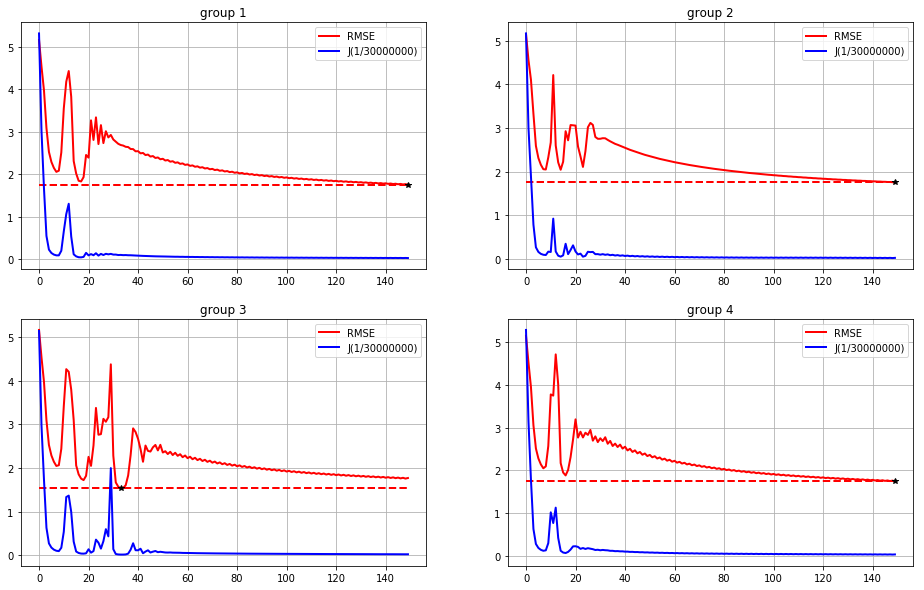

  min RMSE   min J best idx            time
1  1.75122  663990      149  0:13:14.770299
2  1.76015  660199      149  0:13:24.732038
3  1.53125  529424       33  0:15:50.462046
4  1.74194  666091      149  0:15:51.297875


In [18]:
#对k=50,lamda=0.01的情况进行分析并画图
report = pd.DataFrame([],columns=['min RMSE','min J','best idx','time'])
plt.figure(figsize=(16,10))
for runs in range(1,5):
    #不同参数下计算梯度下降算法
    tbegin = datetime.datetime.now()
    l_idx , l_J , l_RMSE = Gradient_Decline( 50 , 0.0002 , 0.01 ,150 )
    tend = datetime.datetime.now()
    report.loc[str(runs),'min RMSE'] = min(l_RMSE)
    report.loc[str(runs),'min J'] = min(l_J)
    report.loc[str(runs),'best idx'] = l_RMSE.index(min(l_RMSE))
    report.loc[str(runs),'time'] = str(tend - tbegin)
    #可视化显示一下结果
    plt.subplot(2,2,runs)
    plt.plot( l_idx , l_RMSE , 'r-' , linewidth = 2 , label='RMSE' )
    plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , 'r--' , linewidth = 2 )
    plt.plot( l_idx , l_J / np.float64(30000000) , 'b-' , linewidth = 2 , label='J(1/30000000)' )
    plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , 'k*' , linewidth = 2 )
    plt.title('group ' + str(runs) )
    plt.grid( True )
    plt.legend()
plt.show()

print report

__实验结果分析：__     
_对比多组不同起始UV的实验数据，我们可以粗浅提出一下几个观察现象：_
1. 使用梯度下降算法确实可以明显将RMSE由初始状态的大于5，逐步震荡下降值一个较低的水平，这里的实验数据表明大概可以达到1.5~1.8之间;
2. RMSE相对于迭代轮数的运行轨迹大致可以描述为逐步震荡下降，且振幅不断缩小，下降速度不断减小，逐步趋近于某一个值，所以并不是不断运行下去就能够获得更优解;
3. J 值的变化与 RMSE 有明显的正相关性，通过设置合理 J 阈值可以有效获得我们可以接受的电影推荐结果，而不需要不断的循环下去;
4. 关于RMSE最小值的出现时间，现有的实验数据和统计范围难以形成客观肯定的结论，这里只能依据现有数据进行一个推测：    
>前期40次以内的运行中就有可能达到最小RMSE;就算后续趋近过程中出现了更小的RMSE，但是也不会有非常明显的下降，而且会逐渐稳定在某一个值上，也就是说，后期的推荐结果不一定比前期的结果有明显的提升。所以在考虑时间成本的情况下，可能可以考虑不做"太多"次的循环，合理设置有效 J 阈值和总循环上限来实现功能。

## 3.2 $k = （20,50）,\lambda = (0.1,0.001)$的4个参数组合进行选取最优组合
#### 1.参数设定：
$\alpha = 0.0002$ ; $最大轮数 = 150$ ; $对照组 = 5$
#### 2.统计数据：
_每个阶段输出的RMSE值_     
_每个阶段输出的J值_     
_最小RMSE出现的轮数_     
_运行时间_     
#### 3.实验形式：
_每个参数组合做5组数据_     

__下面是执行代码以及工作结果:__     
__首先进行所有数据的计算和收集工作__

In [56]:
#alpha学习率固定为0.0002
af = 0.0002
#所有测试跑150轮次
maxrun = 150
#对于每个参数组合重复做5组数据，每组起始UV不同
maxgroup = 5
d_idx  = {}
d_J    = {}
d_RMSE = {}
d_Time = {}
print 'start!'
for k in (20,50):
    for ld in (0.1,0.001):
        for group in range(1,maxgroup+1):
            name = str(k)+'_'+str(ld)+'_'+str(group)
            tbegin = datetime.datetime.now()
            d_idx[name] , d_J[name] , d_RMSE[name] = Gradient_Decline( k , af , ld ,maxrun )
            tend = datetime.datetime.now()
            d_Time[name] = (tend-tbegin).total_seconds()
        print("k = %d , lambda = %f ..... ok!"%(k,ld))

start!
k = 20 , lambda = 0.100000 ..... ok!
k = 20 , lambda = 0.001000 ..... ok!
k = 50 , lambda = 0.100000 ..... ok!
k = 50 , lambda = 0.001000 ..... ok!


In [87]:
#对单组参数组合进行可视化显示
def show_one_para_plot(tk,tld):
    report = pd.DataFrame([],columns=['min RMSE','min J','best idx','time'])
    plt.figure(figsize=(16,10))
    for group in range(1,maxgroup+1):
        name = str(tk)+'_'+str(tld)+'_'+str(group)
        l_idx = d_idx[name]
        l_J = d_J[name]
        l_RMSE = d_RMSE[name]
        l_Time = d_Time[name]
        report.loc[str(group),'min RMSE'] = min(l_RMSE)
        report.loc[str(group),'min J'] = min(l_J)
        report.loc[str(group),'best idx'] = l_RMSE.index(min(l_RMSE))
        report.loc[str(group),'time'] = mean(l_Time)
        #可视化显示一下结果
        plt.subplot(3,3,group)
        plt.plot( l_idx , l_RMSE , 'r-' , linewidth = 2 , label='RMSE' )
        plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , 'r--' , linewidth = 2 )
        plt.plot( l_idx , l_J / np.float64(20000000) , 'b-' , linewidth = 2 , label='J ( 1 / 20000000 )' )
        plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , 'k*' , linewidth = 2 )
        plt.title('group ' + str(group) )
        plt.grid( True )
        plt.legend()
        plt.subplot(3,3,maxgroup+1)
        plt.plot( l_idx , l_RMSE , 'bcgkmry'[group]+'-' , linewidth = 1 , label='group'+str(group) )
        plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , 'bcgkmry'[group]+'--' , linewidth = 1 )
    plt.subplot(3,3,maxgroup+1)
    plt.title('k=' + str(tk) + ',lambda='+str(tld) )
    plt.grid( True )
    plt.legend()
    plt.show()
    report.loc['mean','min RMSE'] = report['min RMSE'].mean()
    report.loc['mean','min J'] = report['min J'].mean()
    report.loc['mean','best idx'] = report['best idx'].mean()
    report.loc['mean','time'] = report['time'].mean()
    print report

__下面首先对所有的参数组合独立进行可视化显示，并求取各个组合下最小RMSE、最小J、最小RMSE idex和运行时间__
### $k = 20 ,\lambda = 0.1$

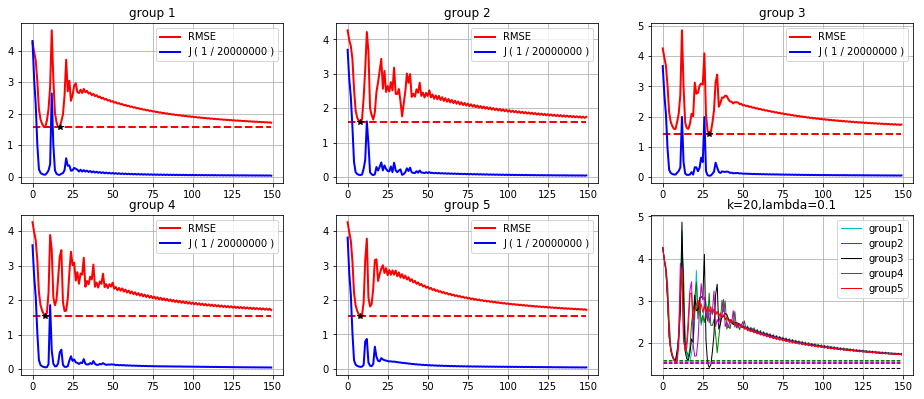

     min RMSE   min J best idx     time
1     1.57013  700128       17   743.01
2     1.58632  805024        8  737.717
3     1.41523  795922       29  840.392
4     1.54887  867831        8  893.278
5     1.52785  792742        8  893.082
mean  1.52968  792329       14  821.496


In [88]:
show_one_para_plot(20,0.1)

### $k = 20 ,\lambda = 0.001$

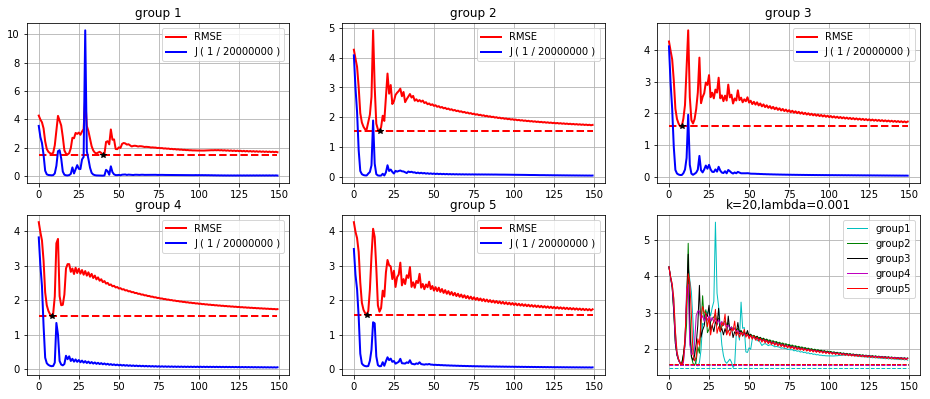

     min RMSE   min J best idx     time
1     1.48242  660529       40  892.106
2     1.54086  913983       16  783.507
3     1.59047  842852        8  893.553
4     1.53953  854405        8  733.325
5      1.5768  805624        8   782.77
mean  1.54602  815479       16  817.052


In [95]:
show_one_para_plot(20,0.001)

### $k = 50 ,\lambda = 0.1$

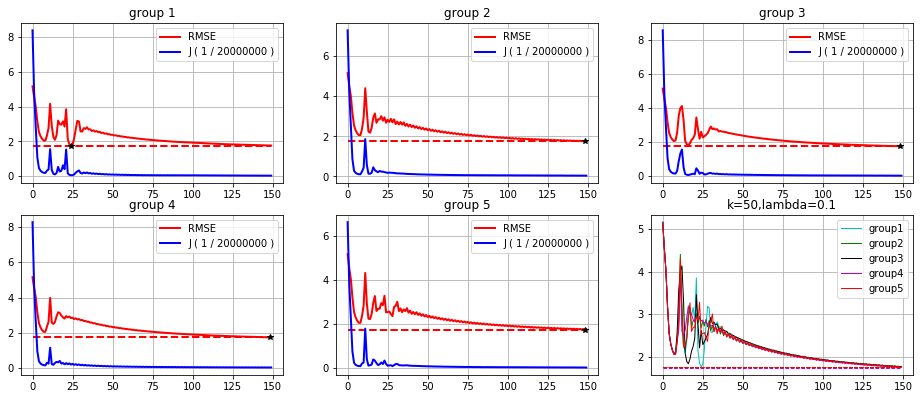

     min RMSE   min J best idx     time
1     1.76271  777505       24   952.17
2     1.75135  722493      148  950.854
3     1.76272  644234      148  950.666
4     1.74338  646408      148  953.071
5     1.75005  689462      148  954.096
mean  1.75404  696021    123.2  952.171


In [79]:
show_one_para_plot(50,0.1)

### $k = 50 ,\lambda = 0.001$

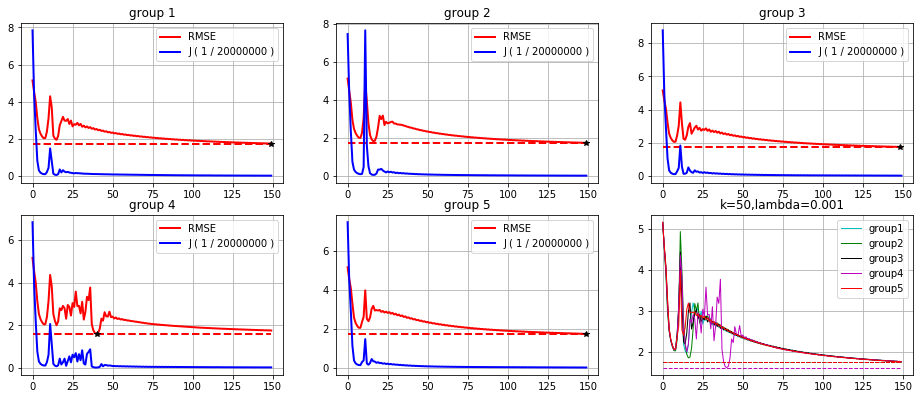

     min RMSE   min J best idx     time
1      1.7573  721173      149  958.097
2     1.75925  700922      149  953.687
3     1.75848  664352      148  952.494
4     1.61863  624427       40  825.828
5     1.75303  696414      149  955.749
mean  1.72934  681458      127  929.171


In [99]:
show_one_para_plot(50,0.001)

__下面将分5个测试组将4中参数组合在同一个图标中显示比对：__

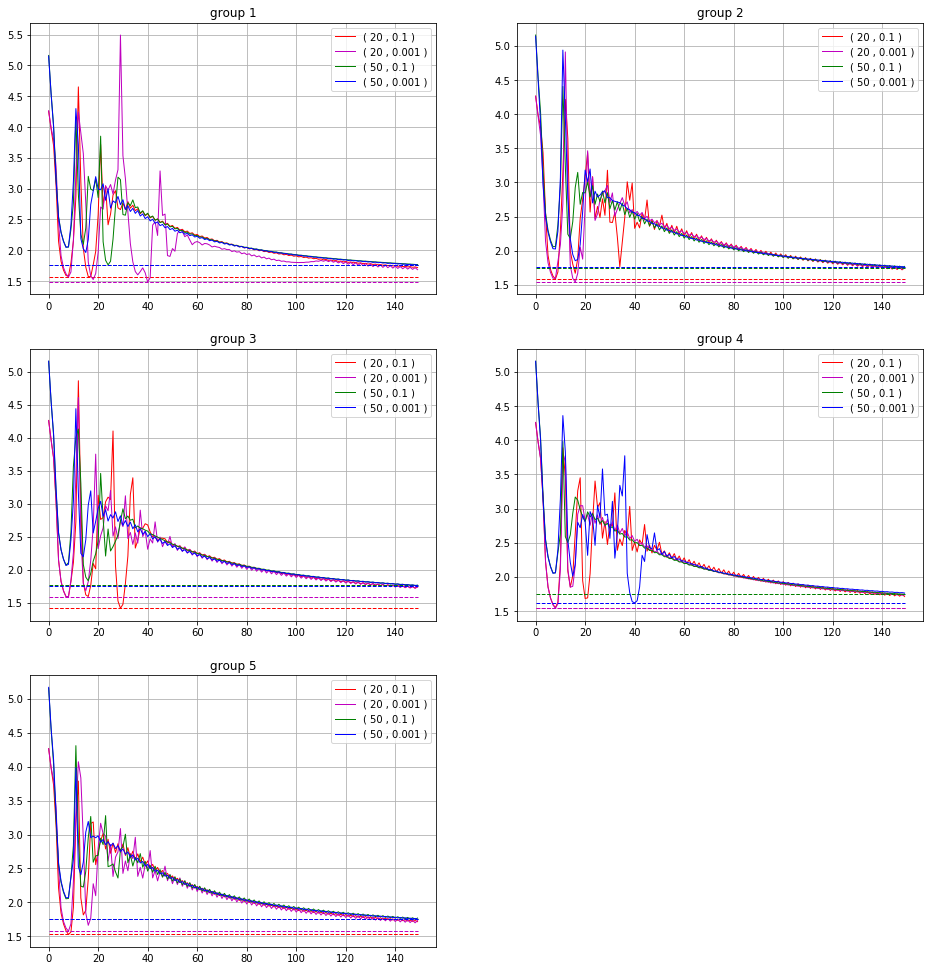

In [116]:
plt.figure(figsize=(16,17))
for group in range(1,maxgroup+1):
    plt.subplot(3,2,group)
    #不同参数下计算梯度下降算法
    lRMSE_20_01 = d_RMSE['20_0.1_'+str(group)]
    lRMSE_20_0001 = d_RMSE['20_0.001_'+str(group)]
    lRMSE_50_01 = d_RMSE['50_0.1_'+str(group)]
    lRMSE_50_0001 = d_RMSE['50_0.001_'+str(group)]
    l_idx = d_idx['20_0.1_'+str(group)]
    #可视化显示一下结果
    plt.plot( l_idx , lRMSE_20_01 , 'r-' , linewidth = 1 , label='( 20 , 0.1 )' )
    plt.plot( (min(l_idx),max(l_idx)) , (min(lRMSE_20_01),min(lRMSE_20_01)) , 'r--' , linewidth = 1 )
    plt.plot( l_idx , lRMSE_20_0001 , 'm-' , linewidth = 1 , label='( 20 , 0.001 )' )
    plt.plot( (min(l_idx),max(l_idx)) , (min(lRMSE_20_0001),min(lRMSE_20_0001)) , 'm--' , linewidth = 1 )
    plt.plot( l_idx , lRMSE_50_01 , 'g-' , linewidth = 1 , label='( 50 , 0.1 )' )
    plt.plot( (min(l_idx),max(l_idx)) , (min(lRMSE_50_01),min(lRMSE_50_01)) , 'g--' , linewidth = 1 )
    plt.plot( l_idx , lRMSE_50_0001 , 'b-' , linewidth = 1 , label='( 50 , 0.001 )' )
    plt.plot( (min(l_idx),max(l_idx)) , (min(lRMSE_50_0001),min(lRMSE_50_0001)) , 'b--' , linewidth = 1 )
    plt.title('group '+str(group))
    plt.grid( True )
    plt.legend()
plt.show()

__通过上述实验数据呈现，这里对结果进行一个讨论：__
### (1).各组均值结果:

|k|$\lambda$|RMSE|J|best Index|Sec|
|-|
|20|0.1|1.52968|792329|14|821.496|
|20|0.001|1.54602|815479|16|817.052|
|50|0.1|1.75404|696021|123.2|952.171|
|50|0.001|1.72934|681458|127|929.171|
__从上述统计结论来看，无论是最小RMSE可达到值和时间损耗，$k=20$都有较好的性能优势，且$k=20$情况下，最小RMSE平均在前20次运算以内就已经达到，达到性能上的极大节省。__     
__对于$k=20$条件下$\lambda$的取值似乎难以看出明显的区别，通过均值最小RMSE和平均最小RMSE出现Index情况判断，选择较好的$\lambda=0.1$。__

### (2).图表结果显示：
__从后面的5副混合图表显示情况来看，可以看出$k=20$的最小值横线（红，粉红）一般都在$k=50$的横线（绿，蓝）之下，且最小值达到位置一般都在前40次循环以内，这里的结果也可以印证(1)中的结论。__

### (3).最终参数选择：
__$k=20$ , $\lambda=0.1$__


# 四、两种推荐算法的对比
### （1）实验结果对比(最低RMSE和时间)
||min RMSE|sec|
|-|
|协同过滤算法|1.01910719672|105|
|矩阵分解|平均1.52968|平均77|
_由于矩阵分解方案的结果和过程可能受到初始UV矩阵取值的影响，这里计算多次结果的均值进行统计。_     
_另外：这里梯度下降算法的参数设置为$k=20$ , $\lambda=0.1$_     
__从这个结果可以看出，协同过滤算法可以达到一个更小的均方根误差结果，而矩阵分解算法可以在较短时间内达到可取的最小值。__     
__但是需要说明的是这里的实验数据仅仅使用了多个参数组合中的一组，只证明了这组参数组合的结果情况，在没有进行大范围的参数调优的情况下，不能通过这个实验数据直接证明两种方案的优劣。__

### （2）时间空间复杂度
__矩阵分解算法具有比较低的时间和空间复杂度，将一个很大的矩阵运算问题转化为求解两个较小的矩阵的乘积问题，且通过不断的迭代，使结果更加趋近于一个理想的结果，同时也具有较好的可拓展性。而协同过滤算法则不得不一次性消耗较大的运算空间和更长的时间来解决大矩阵的存储和运算的问题，尤其是矩阵乘操作，当实际数据足够大足够复杂的情况下，协同过滤则显得捉襟见肘，不得不依赖更好的硬件环境支持或是考虑选取局部数据进行运算。__

### （3）可解释性
__矩阵分解算法最终得到的U矩阵和V矩阵不具有很好的可解释性。因为把评分矩阵分解成user-factor矩阵和item-factor矩阵，这里的factor很难用实际意义的概念来解释。但是协同过滤算法就不存在这个问题。__